✅ Dataset Loaded: (506, 14)

🔍 Missing Values Count:
CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

✅ Missing Values Filled

✅ Encoding Done | Shape: (506, 14)

📊 Skewness of Numeric Features:
 CRIM       5.223149
CHAS       3.405904
ZN         2.225666
MEDV       1.108098
DIS        1.011781
RAD        1.004815
LSTAT      0.906460
NOX        0.729308
TAX        0.669956
RM         0.403612
INDUS      0.295022
AGE       -0.598963
PTRATIO   -0.802325
B         -2.890374
dtype: float64

✅ Log Transform Applied


/tmp/ipython-input-3325958371.py:34: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)



📈 Model Performance:
RMSE: 0.1452
R² Score: 0.8479


/tmp/ipython-input-3325958371.py:132: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feat_importances[:10], y=feat_importances.index[:10], palette="viridis", ax=axes[1,2])


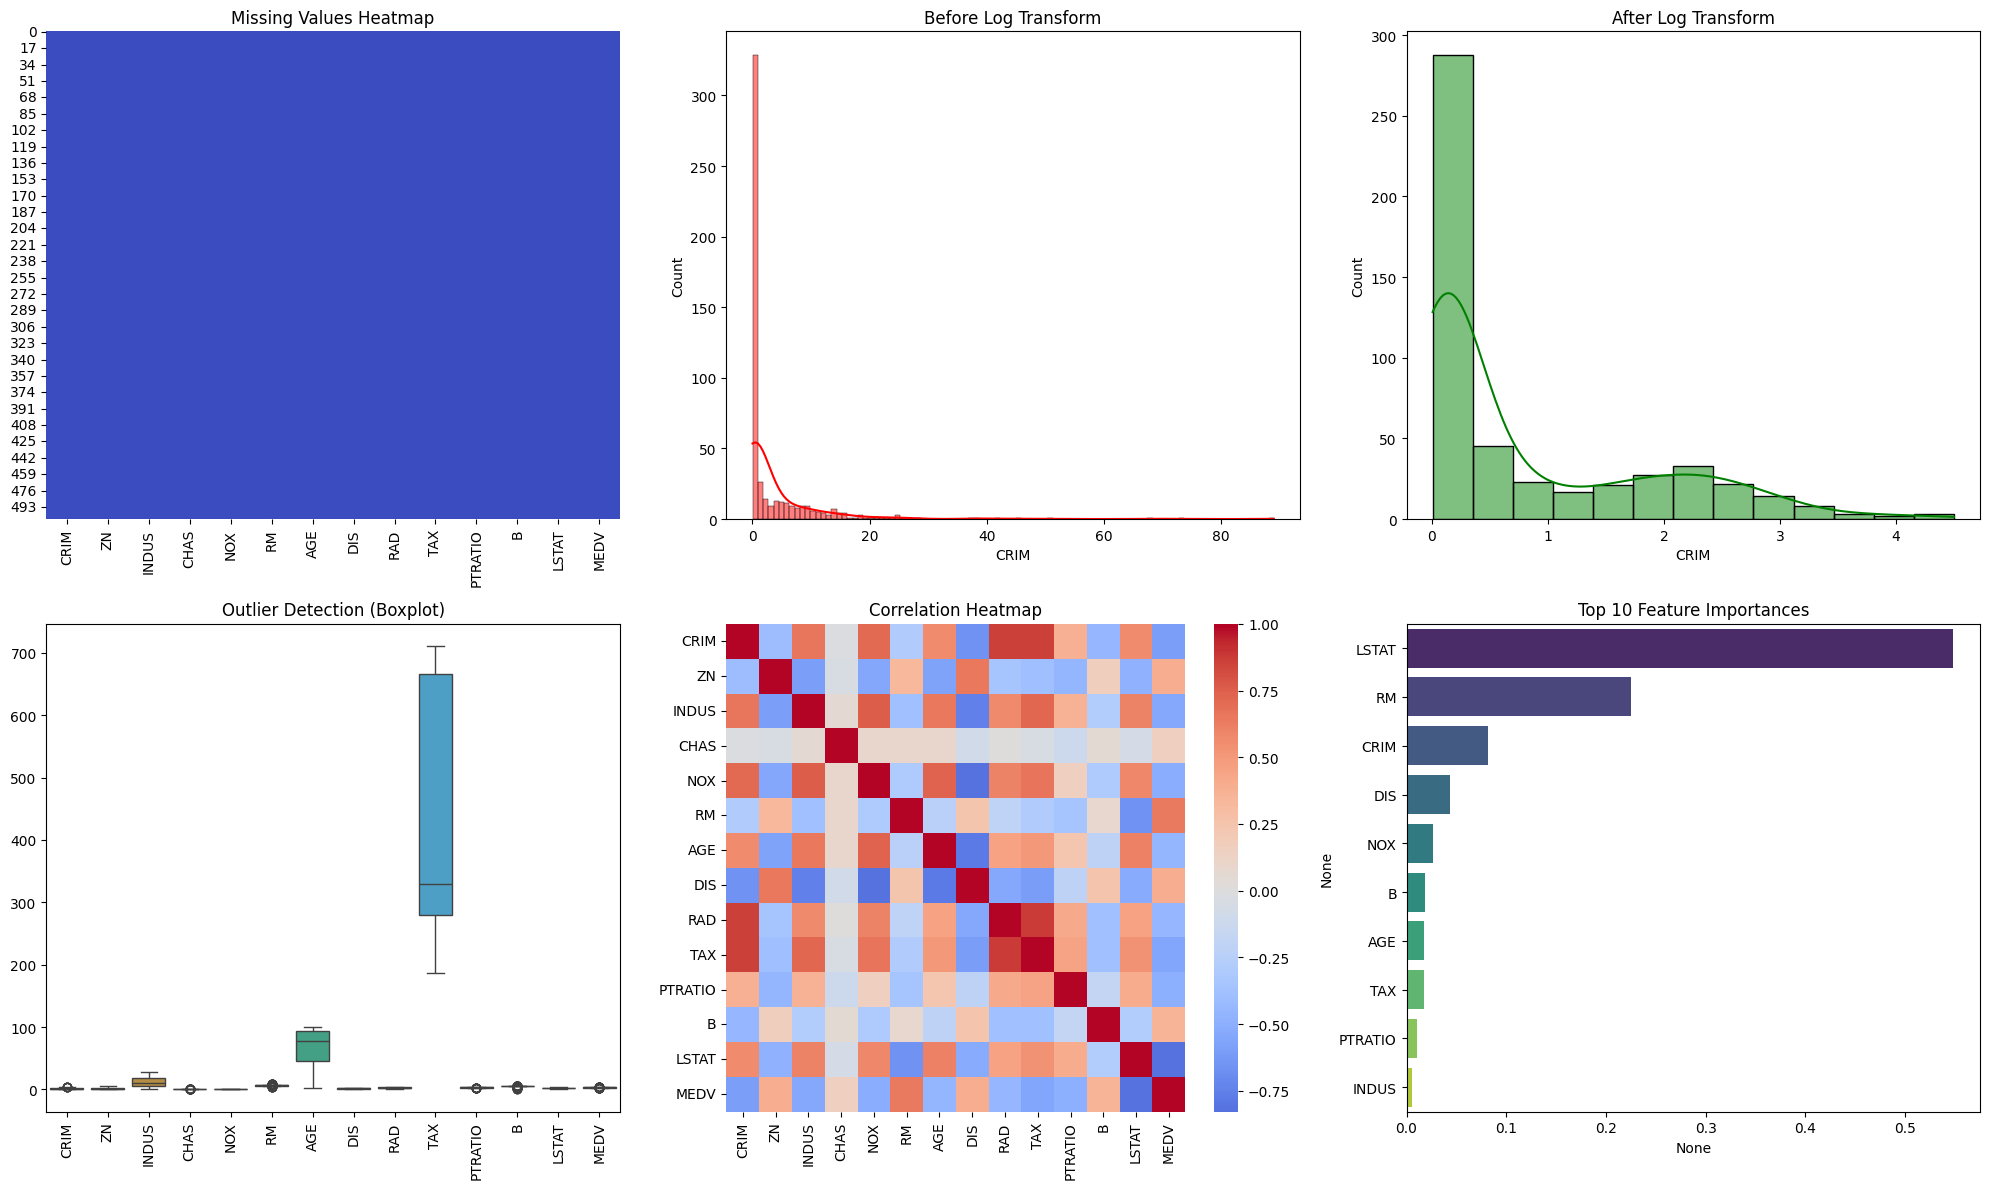

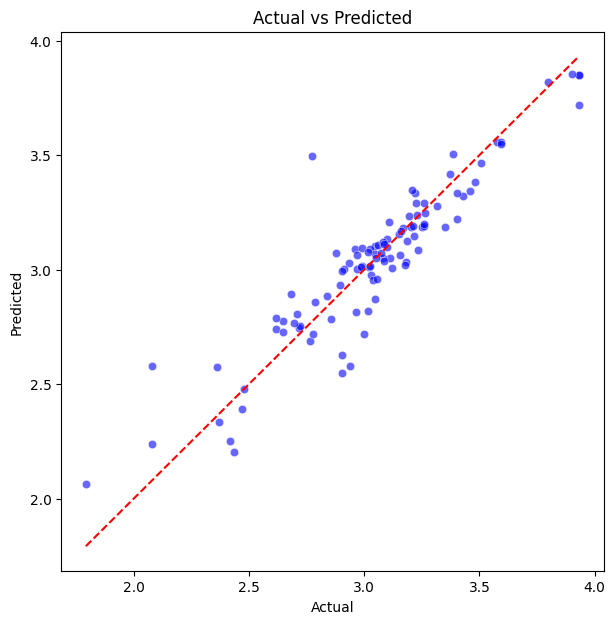


✅ Full Visual Feature Engineering + Modeling Completed


In [ ]:
# -------------------------------
# 1. Import Required Libraries
# -------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# -------------------------------
# 2. Load Dataset
# -------------------------------
from google.colab import files
# uploaded = files.upload()

df = pd.read_csv("/content/boston.csv")
print("✅ Dataset Loaded:", df.shape)

# -------------------------------
# 3. Missing Values Analysis
# -------------------------------
print("\n🔍 Missing Values Count:")
print(df.isnull().sum())

# Fill numeric missing values with median, categorical with mode
for col in df.columns:
    if df[col].dtype == "object":
        df[col].fillna(df[col].mode()[0], inplace=True)
    else:
        df[col].fillna(df[col].median(), inplace=True)

print("\n✅ Missing Values Filled")

# -------------------------------
# 4. Encoding Categorical Variables
# -------------------------------
categorical_cols = df.select_dtypes(include=["object"]).columns
ordinal_cols = []  # Add specific ordinal cols if known

le = LabelEncoder()
for col in ordinal_cols:
    df[col] = le.fit_transform(df[col])

df = pd.get_dummies(df, drop_first=True)
print("\n✅ Encoding Done | Shape:", df.shape)

# -------------------------------
# 5. Skewness & Log Transformation
# -------------------------------
numeric_cols = df.select_dtypes(include=[np.number]).columns
skewed_feats = df[numeric_cols].apply(lambda x: x.skew()).sort_values(ascending=False)

print("\n📊 Skewness of Numeric Features:\n", skewed_feats)

# Apply log1p for skewed features
for col in skewed_feats.index:
    if abs(skewed_feats[col]) > 0.75:
        df[col] = np.log1p(df[col])

print("\n✅ Log Transform Applied")

# -------------------------------
# 6. Define Features & Target
# -------------------------------
target_col = "MEDV" if "MEDV" in df.columns else df.columns[-1]
X = df.drop(target_col, axis=1)
y = df[target_col]

# -------------------------------
# 7. Train-Test Split
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# -------------------------------
# 8. Train Model
# -------------------------------
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

# -------------------------------
# 9. Evaluation
# -------------------------------
y_pred = rf.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("\n📈 Model Performance:")
print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

# -------------------------------
# 10. Feature Importances
# -------------------------------
importances = rf.feature_importances_
feat_importances = pd.Series(importances, index=X.columns).sort_values(ascending=False)

# -------------------------------
# 11. Combined Visualization Grid
# -------------------------------
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# 1. Missing values heatmap
sns.heatmap(df.isnull(), cbar=False, cmap="coolwarm", ax=axes[0,0])
axes[0,0].set_title("Missing Values Heatmap")

# 2. Example feature distribution (Before Log Transform)
sns.histplot(np.expm1(df[numeric_cols].iloc[:,0]), kde=True, color="red", ax=axes[0,1])
axes[0,1].set_title("Before Log Transform")

# 3. Example feature distribution (After Log Transform)
sns.histplot(df[numeric_cols].iloc[:,0], kde=True, color="green", ax=axes[0,2])
axes[0,2].set_title("After Log Transform")

# 4. Boxplot for outlier detection
sns.boxplot(data=df[numeric_cols], ax=axes[1,0])
axes[1,0].set_title("Outlier Detection (Boxplot)")
axes[1,0].tick_params(axis='x', rotation=90)

# 5. Correlation Heatmap
sns.heatmap(df.corr(), cmap="coolwarm", center=0, ax=axes[1,1])
axes[1,1].set_title("Correlation Heatmap")

# 6. Feature Importances
sns.barplot(x=feat_importances[:10], y=feat_importances.index[:10], palette="viridis", ax=axes[1,2])
axes[1,2].set_title("Top 10 Feature Importances")

plt.tight_layout()
plt.show()

# -------------------------------
# 12. Actual vs Predicted (Standalone big chart)
# -------------------------------
plt.figure(figsize=(7,7))
sns.scatterplot(x=y_test, y=y_pred, color="blue", alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted")
plt.show()

print("\n✅ Full Visual Feature Engineering + Modeling Completed")
